In [1]:
import numpy
from numpy.linalg import solve, norm
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import time

In [3]:
def make_blood_flow_params(L, R, h, rho, mu, E, poisson):
    params = {
        'L': L,           # vessel length [m]
        'R': R,           # lumen radius [m]
        'h': h,           # wall thickness [m]
        'rho': rho,       # blood density [kg/m³]
        'mu': mu,         # dynamic viscosity [Pa·s]
        'E': E,           # Young's modulus [Pa]
        'poisson': poisson  # Poisson's ratio [-]
    }
    
    # Derived geometric parameters
    params['A0'] = numpy.pi * R**2  # diastolic cross-sectional area [m²]
    
    # Wave speed in compliant tube (Moens-Korteweg equation modified)
    # c₀ = sqrt(E·h / (2·ρ·R·(1 - ν²)))
    params['c0'] = numpy.sqrt(E * h / (2 * rho * R * (1 - poisson**2)))
    
    # Viscous resistance coefficient for Poiseuille flow
    # R_visc = 8μ / (π·R⁴)
    params['R_visc'] = 8 * mu / (numpy.pi * R**4)
    
    return params



# Geometry
R = 0.0086       # m, lumen radius (0.86 cm)
h = 0.000602     # m, wall thickness (0.0602 cm)
L = 0.04         # m, vessel length (4 cm segment)

# Fluid Properties
rho = 1055.0     # kg/m³, blood density (1.055 g/cm³)
mu = 0.0035      # Pa·s, dynamic viscosity

# Wall Material Properties
E = 1.4812e6     # Pa, Young's modulus
poisson = 0.25   # Poisson's ratio

# Create parameter dictionary
params = make_blood_flow_params(L, R, h, rho, mu, E, poisson)

# Print key derived parameters for verification
print("=== Derived Parameters ===")
print(f"Cross-sectional area A₀ = {params['A0']*1e6:.4f} mm²")
print(f"Wave speed c₀ = {params['c0']:.2f} m/s")
print(f"Viscous resistance R_visc = {params['R_visc']:.2e} Pa·s/m³")

=== Derived Parameters ===
Cross-sectional area A₀ = 232.3522 mm²
Wave speed c₀ = 7.24 m/s
Viscous resistance R_visc = 1.63e+06 Pa·s/m³


In [7]:
# ## Finite Element Method (FEM)
# 
# Discretize the domain into N elements and solve the resulting linear system.
# We use central finite differences for the second derivative.

# %% FEM Implementation

def fem_method(params, p_in, p_out, N, omega):
    """
    Solve the 1D pressure wave equation using finite differences.
    
    Discretizes: d²p/dx² = α² p
    Using central differences: (p_{i-1} - 2p_i + p_{i+1})/h² = α² p_i
    
    Parameters
    ----------
    params : dict
        Parameter dictionary from make_blood_flow_params()
    p_in : float
        Inlet pressure [Pa]
    p_out : float
        Outlet pressure [Pa]
    N : int
        Number of elements (N+1 nodes)
    omega : float
        Angular frequency [rad/s]
    
    Returns
    -------
    x_nodes : ndarray
        Node positions [m]
    p_fem : ndarray
        Pressure at each node [Pa]
    q_fem : ndarray
        Flow rate at each node [m³/s]
    alpha : float
        Wave number
    R_visc : float
        Viscous resistance coefficient
    """
    # Extract parameters
    L = params['L']
    c0 = params['c0']
    R_visc = params['R_visc']
    rho = params['rho']
    
    # Compute wave number α (same as shooting method)
    alpha_sq = (omega**2 / c0**2) + (R_visc * omega / (rho * c0**2))
    alpha = numpy.sqrt(alpha_sq)
    
    # -------------------------------------------------------------------------
    # Create mesh
    # -------------------------------------------------------------------------
    h = L / N  # element size
    x_nodes = numpy.linspace(0, L, N + 1)
    
    # -------------------------------------------------------------------------
    # Assemble system matrix A
    # 
    # For interior nodes (i = 1, ..., N-1):
    #   (p_{i-1} - 2p_i + p_{i+1})/h² = α² p_i
    #   → p_{i-1}/h² + (-2/h² - α²)p_i + p_{i+1}/h² = 0
    #
    # Boundary nodes: p_0 = p_in, p_N = p_out (Dirichlet)
    # -------------------------------------------------------------------------
    A = numpy.zeros((N + 1, N + 1))
    
    # Interior nodes: finite difference stencil
    for i in range(1, N):
        A[i, i - 1] = 1 / h**2           # coefficient for p_{i-1}
        A[i, i] = -2 / h**2 - alpha_sq   # coefficient for p_i
        A[i, i + 1] = 1 / h**2           # coefficient for p_{i+1}
    
    # Boundary conditions (Dirichlet)
    A[0, 0] = 1    # p(0) = p_in
    A[N, N] = 1    # p(L) = p_out
    
    # -------------------------------------------------------------------------
    # Right-hand side vector
    # -------------------------------------------------------------------------
    f = numpy.zeros(N + 1)
    f[0] = p_in    # inlet boundary condition
    f[N] = p_out   # outlet boundary condition
    
    # -------------------------------------------------------------------------
    # Solve linear system
    # -------------------------------------------------------------------------
    p_fem = numpy.linalg.solve(A, f)
    
    # -------------------------------------------------------------------------
    # Compute pressure gradient dp/dx using finite differences
    # - Forward difference at inlet (2nd order)
    # - Backward difference at outlet (2nd order)
    # - Central difference at interior nodes
    # -------------------------------------------------------------------------
    dpdx_fem = numpy.zeros(N + 1)
    
    # Forward difference at x = 0: dp/dx ≈ (-3p_0 + 4p_1 - p_2) / (2h)
    dpdx_fem[0] = (-3 * p_fem[0] + 4 * p_fem[1] - p_fem[2]) / (2 * h)
    
    # Backward difference at x = L: dp/dx ≈ (3p_N - 4p_{N-1} + p_{N-2}) / (2h)
    dpdx_fem[N] = (3 * p_fem[N] - 4 * p_fem[N - 1] + p_fem[N - 2]) / (2 * h)
    
    # Central difference at interior nodes: dp/dx ≈ (p_{i+1} - p_{i-1}) / (2h)
    for i in range(1, N):
        dpdx_fem[i] = (p_fem[i + 1] - p_fem[i - 1]) / (2 * h)
    
    # -------------------------------------------------------------------------
    # Compute flow rate from pressure gradient
    # q = -dp/dx / R_visc (from Poiseuille flow relation)
    # -------------------------------------------------------------------------
    q_fem = -dpdx_fem / R_visc
    
    return x_nodes, p_fem, q_fem, alpha, R_visc

In [5]:
# ## Shooting Method
# 
# Solve the boundary value problem by converting it to an initial value problem.
# We guess the initial slope dp/dx(0) and integrate forward, then adjust
# the guess until p(L) matches the outlet boundary condition.

# %% Shooting Method Implementation

def shooting_method(params, p_in, p_out, omega):
    """
    Solve the 1D pressure wave equation using the shooting method.
    
    The governing equation is:
        d²p/dx² = α² p
    
    with boundary conditions:
        p(0) = p_in
        p(L) = p_out
    
    Parameters
    ----------
    params : dict
        Parameter dictionary from make_blood_flow_params()
    p_in : float
        Inlet pressure [Pa]
    p_out : float
        Outlet pressure [Pa]
    omega : float
        Angular frequency [rad/s]
    
    Returns
    -------
    sol : OdeSolution
        Solution object with dense output for interpolation
    alpha : float
        Wave number (complex in general)
    R_visc : float
        Viscous resistance coefficient
    """
    # Extract parameters
    L = params['L']
    c0 = params['c0']
    R_visc = params['R_visc']
    rho = params['rho']
    
    # Compute wave number α
    # α² = ω²/c₀² + R_visc·ω/(ρ·c₀²)
    # The second term accounts for viscous dissipation
    alpha_sq = (omega**2 / c0**2) + (R_visc * omega / (rho * c0**2))
    alpha = numpy.sqrt(alpha_sq)
    
    # Define ODE system
    # Convert 2nd order ODE to system of 1st order ODEs:
    #   Y[0] = p
    #   Y[1] = dp/dx
    # Then:
    #   dY[0]/dx = Y[1]
    #   dY[1]/dx = α² · Y[0]
    def ode_system(x, Y):
        p, dpdx = Y
        return [dpdx, alpha**2 * p]
    
    # Residual function for root finding
    # We want to find dp/dx(0) such that p(L) = p_out
    def residual(dpdx_0):
        sol = solve_ivp(
            ode_system, 
            [0.0, L], 
            [p_in, dpdx_0], 
            rtol=1e-12, 
            atol=1e-14
        )
        return sol.y[0, -1] - p_out
    
    # Initial guess from analytical solution
    # The analytical solution is: p(x) = A·sinh(αx) + B·cosh(αx)
    # With p(0) = p_in → B = p_in
    # With p(L) = p_out → A = (p_out - p_in·cosh(αL)) / sinh(αL)
    # Then dp/dx(0) = α·A
    A_coef = (p_out - p_in * numpy.cosh(alpha * L)) / numpy.sinh(alpha * L)
    dpdx_0_est = alpha * A_coef
    
    # Bracket search for root finding
    # Search around the analytical estimate to find sign change
    search_range = numpy.linspace(
        dpdx_0_est - abs(dpdx_0_est) * 2 - 1e4,
        dpdx_0_est + abs(dpdx_0_est) * 2 + 1e4,
        51
    )
    residuals = [residual(dp) for dp in search_range]
    
    # Find bracket where residual changes sign
    bracket = None
    for i in range(len(residuals) - 1):
        if residuals[i] * residuals[i + 1] < 0:
            bracket = [search_range[i], search_range[i + 1]]
            break
    
    if bracket is None:
        raise ValueError("Could not find bracket for root finding")
    
    # Solve for exact initial slope using Brent's method
    result = root_scalar(
        residual, 
        bracket=bracket, 
        method='brentq', 
        rtol=1e-12
    )
    dpdx_0 = result.root
    
    # Final solution with dense output for smooth interpolation
    sol = solve_ivp(
        ode_system, 
        [0.0, L], 
        [p_in, dpdx_0],
        rtol=1e-12, 
        atol=1e-14, 
        dense_output=True
    )
    
    return sol, alpha, R_visc

=== Simulation Parameters ===
Inlet pressure:  p_in = 1000.0 Pa
Outlet pressure: p_out = 900.0 Pa
Angular frequency: ω = 6.2832 rad/s (1.00 Hz)
FEM elements: N = 80

Solving with shooting method...
  Wave number α = 13.634007
Solving with FEM...
  Done.


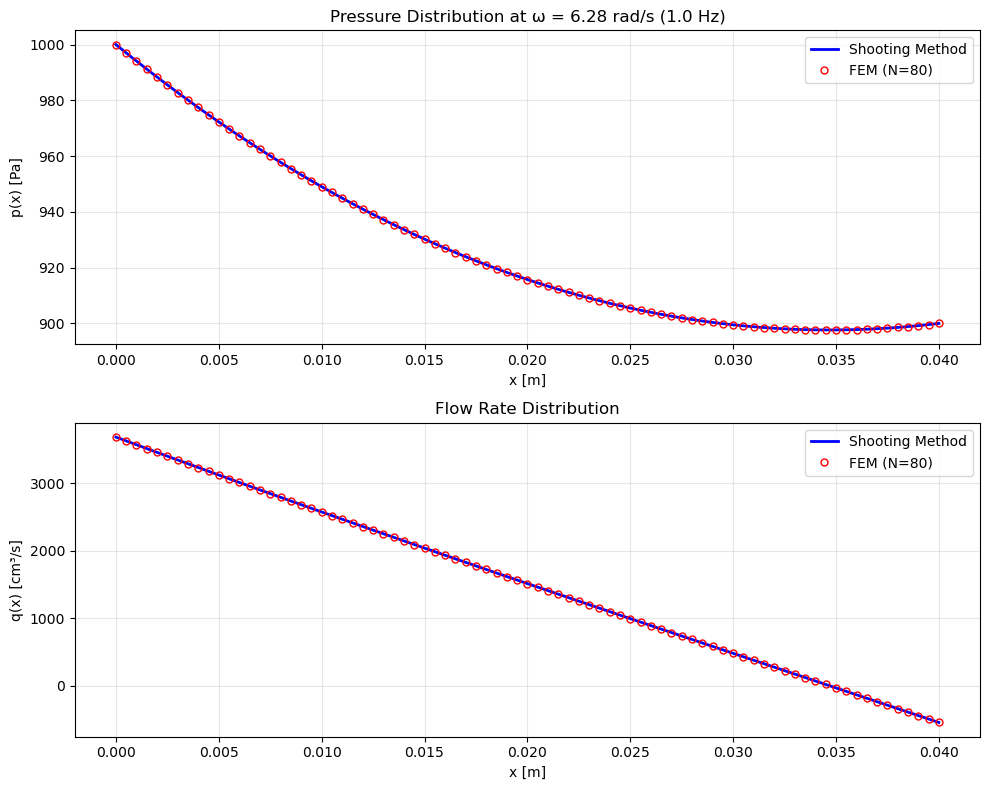


Figure saved as 'blood_flow_comparison.png'
=== Verification: Method Comparison ===
Max |p_shooting - p_FEM| = 9.29e-04 Pa
Max |q_shooting - q_FEM| = 6.46e-02 cm³/s

Relative errors:
  Pressure: 0.0001%
  Flow rate: 0.0018%

Boundary condition verification:
  p(0) = 1000.00 Pa (expected: 1000.0 Pa)
  p(L) = 900.00 Pa (expected: 900.0 Pa)


In [9]:
# ## Solve and Compare Methods
# 
# Set boundary conditions and frequency, then solve using both methods.

# Boundary conditions
p_in = 1000.0    # Pa, inlet pressure
p_out = 900.0    # Pa, outlet pressure

# Frequency (oscillatory flow)
omega = 2 * numpy.pi  # rad/s (corresponds to 1 Hz)

# FEM mesh resolution
N = 80  # number of elements

print("=== Simulation Parameters ===")
print(f"Inlet pressure:  p_in = {p_in} Pa")
print(f"Outlet pressure: p_out = {p_out} Pa")
print(f"Angular frequency: ω = {omega:.4f} rad/s ({omega/(2*numpy.pi):.2f} Hz)")
print(f"FEM elements: N = {N}")


# Shooting method solution
print("\nSolving with shooting method...")
sol_shoot, alpha, R_visc = shooting_method(params, p_in, p_out, omega)
print(f"  Wave number α = {alpha:.6f}")

# FEM solution
print("Solving with FEM...")
x_fem, p_fem, q_fem, _, _ = fem_method(params, p_in, p_out, N, omega)
print("  Done.")

# Evaluate shooting solution on fine grid for smooth plotting
x_fine = numpy.linspace(0, params['L'], 200)

# Extract pressure and its derivative from shooting solution
p_shoot = numpy.array([sol_shoot.sol(x)[0] for x in x_fine])
dpdx_shoot = numpy.array([sol_shoot.sol(x)[1] for x in x_fine])

# Compute flow rate from pressure gradient
q_shoot = -dpdx_shoot / R_visc



# Plot pressure and flow rate distributions comparing both methods

fig, axes = plt.subplots(2, 1, figsize=(10, 8))


# Pressure distribution p(x)
ax1 = axes[0]
ax1.plot(x_fine, p_shoot, 'b-', linewidth=2, label='Shooting Method')
ax1.plot(x_fem, p_fem, 'ro', markersize=5, markerfacecolor='none', 
         label=f'FEM (N={N})')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('p(x) [Pa]')
ax1.set_title(f'Pressure Distribution at ω = {omega:.2f} rad/s ({omega/(2*numpy.pi):.1f} Hz)')
ax1.legend()
ax1.grid(True, alpha=0.3)


# Flow rate distribution q(x)
# Convert to cm³/s for readability (multiply by 1e6)
ax2 = axes[1]
ax2.plot(x_fine, q_shoot * 1e6, 'b-', linewidth=2, label='Shooting Method')
ax2.plot(x_fem, q_fem * 1e6, 'ro', markersize=5, markerfacecolor='none', 
         label=f'FEM (N={N})')
ax2.set_xlabel('x [m]')
ax2.set_ylabel('q(x) [cm³/s]')
ax2.set_title('Flow Rate Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('blood_flow_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'blood_flow_comparison.png'")



# ## Verification
# Compare numerical results between the two methods to verify accuracy.


#Compute Error Metrics
# Interpolate shooting solution to FEM nodes for direct comparison
p_shoot_at_fem_nodes = numpy.interp(x_fem, x_fine, p_shoot)
q_shoot_at_fem_nodes = numpy.interp(x_fem, x_fine, q_shoot)

# Compute maximum absolute differences
max_p_error = numpy.max(numpy.abs(p_shoot_at_fem_nodes - p_fem))
max_q_error = numpy.max(numpy.abs(q_shoot_at_fem_nodes - q_fem))

print("=== Verification: Method Comparison ===")
print(f"Max |p_shooting - p_FEM| = {max_p_error:.2e} Pa")
print(f"Max |q_shooting - q_FEM| = {max_q_error * 1e6:.2e} cm³/s")

# Relative errors
rel_p_error = max_p_error / numpy.max(numpy.abs(p_fem)) * 100
rel_q_error = max_q_error / numpy.max(numpy.abs(q_fem)) * 100

print(f"\nRelative errors:")
print(f"  Pressure: {rel_p_error:.4f}%")
print(f"  Flow rate: {rel_q_error:.4f}%")

# Check boundary conditions
print(f"\nBoundary condition verification:")
print(f"  p(0) = {p_fem[0]:.2f} Pa (expected: {p_in} Pa)")
print(f"  p(L) = {p_fem[-1]:.2f} Pa (expected: {p_out} Pa)")

## HOW TO GET Equations

**Continuity equation (mass conservation):**
$\frac{\partial A}{\partial t} + \frac{\partial q}{\partial x} = 0$

where A is cross-sectional area, q is volumetric flow rate.

**Momentum equation (Navier-Stokes for 1D):**
$\rho \frac{\partial q}{\partial t} + \rho \frac{\partial}{\partial x}\left(\frac{q^2}{A}\right) = -A\frac{\partial p}{\partial x} - \frac{8\pi\mu}{A}q$

## Linearization

For small harmonic perturbations about equilibrium: $p = p_0 + \tilde{p}e^{i\omega t}$, $q = q_0 + \tilde{q}e^{i\omega t}$

Assume $q_0 = 0$ (no mean flow), and drop nonlinear terms.

**From continuity:**
$\frac{\partial A}{\partial t} = -\frac{\partial q}{\partial x}$

Using compliance: $C = \frac{1}{A_0}\frac{dA}{dp}$, so $\frac{\partial A}{\partial t} = A_0 C \frac{\partial p}{\partial t}$

This gives:
$\frac{\partial q}{\partial x} = -A_0 C \frac{\partial p}{\partial t} = -i\omega A_0 C \cdot p$

**From momentum (linearized):**
$\rho A_0 \frac{\partial q}{\partial t} = -A_0\frac{\partial p}{\partial x} - \frac{8\pi\mu}{A_0}q$

Dividing by $A_0$:
$\frac{\partial p}{\partial x} = -\rho\frac{\partial q}{\partial t} - \frac{8\pi\mu}{A_0^2}q = -i\omega\rho \cdot q - \frac{8\pi\mu}{A_0^2}q$

Define: $L = \rho$ (inertance per unit length), $R = \frac{8\pi\mu}{A_0^2}$ (resistance per unit length)

## Final Coupled System

$\frac{dq}{dx} = -i\omega C \cdot p$

$\frac{dp}{dx} = -(R + i\omega L) \cdot q$

**Matrix form:**
$\frac{d}{dx}\begin{bmatrix} p \\ q \end{bmatrix} = \begin{bmatrix} 0 & -(R+i\omega L) \\ -i\omega C & 0 \end{bmatrix} \begin{bmatrix} p \\ q \end{bmatrix}$
